In [127]:
import ipywidgets as widgets
from ipywidgets import interact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
import json

In [128]:
def cosd(x):
    return np.cos(x * np.pi / 180)

def sind(x):
    return np.sin(x * np.pi / 180)

def tand(x):
    return np.tan(x * np.pi / 180)

In [133]:
df = pd.read_csv('../datasets/state_data.csv')
sh, sw, _ = cv2.imread('../datasets/imgs/0.jpg').shape
print(sw)
data_ims = np.zeros((50, sh, sw, 3), dtype=int)
# load hfov and vfov
with open('metadata.json','r') as datafile:
    metadata = json.load(datafile)
hfov = metadata["hfov"]
vfov = metadata["vfov"]
for i in range(10):
    data_ims[i, :, :, :] = np.array(cv2.cvtColor(cv2.imread(
        '../datasets/imgs/' + str(i) + '.jpg'), cv2.COLOR_BGRA2BGR)[:, :, ::-1])

2560


In [130]:
def get_bounding_box(r, hang, vang, tilt=0, offset=0, aw0=0, daw=1):
    h_frac = hang / hfov # percentage from center
    v_frac = vang / vfov * -1
    x_p = (sw/2) * h_frac # pixels from center
    y_p = (sh/2) * v_frac
    x_p += sw/2
    y_p += sh/2
    print(f"{h_frac}, {v_frac}, {x_p}, {y_p}")
    
    return x_p, y_p, 50, 50
    

def get_bounding_box2(e0, n0, u0, h0, e1, n1, u1, p0, tilt=0, hfov=80, vfov=50.25, offset=0, aw0=0, daw=1):

    # Make ownship be the origin
    x = n1 - n0
    y = -(e1 - e0) # right-handed coordinates
    z = u1 - u0

    # Rotate x and y according to ownship heading
    xrot = x * cosd(h0) - y * sind(h0)
    yrot = -(x * sind(h0) + y * cosd(h0))

    # Account for offset
    z = z + offset

    # Rotate z according to tilt angle
    xcam = xrot * cosd(tilt) - z * sind(tilt)
    ycam = yrot
    zcam = xrot * sind(tilt) + z * cosd(tilt)

    # https://www.youtube.com/watch?v=LhQ85bPCAJ8
    xp = ycam / (xcam * tand(hfov / 2))
    yp = zcam / (xcam * tand(vfov / 2))

    # Get xp and yp between 0 and 1
    xp = (xp + 1) / 2
    yp = (yp + 1) / 2

    # Map to pixel location
    xp = xp * sw
    yp = (1 - yp) * sh

    # Get height and width of bounding box
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    w = daw * (1 / r) + aw0
    h = (3 / 8) * w

    # print(r)
    print(f"{xp}, {yp}, {w}, {h}")
    return xp, yp, w, h

In [131]:
def show_img_w_bb(im, xp, yp, w, h):
    f, ax = plt.subplots()
    f.set_figwidth(14)
    f.set_figheight(14)

    ax.imshow(im)

    rect = patches.Rectangle((xp - (w / 2), yp - (h / 2)), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [134]:
def data_interact_bb(i, aw0, daw, hfov, vfov, offset, tilt):
    #xp, yp, w, h = get_bounding_box(df['e0'][i], df['n0'][i], df['u0'][i], df['h0'][i], df['e1'][i],
                                    #df['n1'][i], df['u1'][i], df['p0'][i], aw0=aw0, daw=daw, hfov=hfov, vfov=vfov, offset=offset, tilt=tilt)
    #xp, yp, w, h = get_bounding_box(df['vang'][i], df['hang'][i])
    xp, yp, w, h = get_bounding_box(df['z'][i], df['hang'][i], df['vang'][i])
    
    #xp, yp, w, h = get_bounding_box2(df['z'][i], df['e0'][i], df['n0'][i], df['u0'][i], df['h0'][i], df['p0'][i], df['r0'][i], df['e1'][i], df['n1'][i], df['u1'][i])
    #xp, yp, w, h = get_bounding_box3(df['vang'][i], df['hang'][i])
    #print(w)
    # print(h)
    show_img_w_bb(data_ims[i, :, :, :], xp, yp, w, h)

interact(data_interact_bb,
         aw0=widgets.FloatSlider(min=-10, max=10, step=1, value=0),
         daw=widgets.FloatSlider(min=13000, max=18000, step=200, value=17000),
         hfov=widgets.FloatText(value=56.5),
         vfov=widgets.FloatText(value=51.5),
         offset=widgets.FloatSlider(min=-10, max=10, step=0.25, value=0),
         tilt=widgets.FloatText(value=5),
         i=widgets.IntText(value=0))

interactive(children=(IntText(value=0, description='i'), FloatSlider(value=0.0, description='aw0', max=10.0, m…

<function __main__.data_interact_bb(i, aw0, daw, hfov, vfov, offset, tilt)>

In [92]:
def show_imgs_w_bbs(im_inds, grid_dims=(3, 3), figsize=(18., 12.), hfov=90, vfov=45, offset=0, tilt=10, daw=15200, aw0=0):
    fig = plt.figure(figsize=figsize)

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=grid_dims,  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for (i, ax) in zip(im_inds, grid):
        ax.imshow(im_inds[i,:,:,:])
        xp, yp, w, h = get_bounding_box(df['e0'][i], df['n0'][i], df['u0'][i], df['h0'][i], df['e1'][i],
                                        df['n1'][i], df['u1'][i], aw0=aw0, daw=daw, hfov=hfov, vfov=vfov, offset=offset, tilt=tilt)
        rect = patches.Rectangle(
            (xp - (w / 2), yp - (h / 2)), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

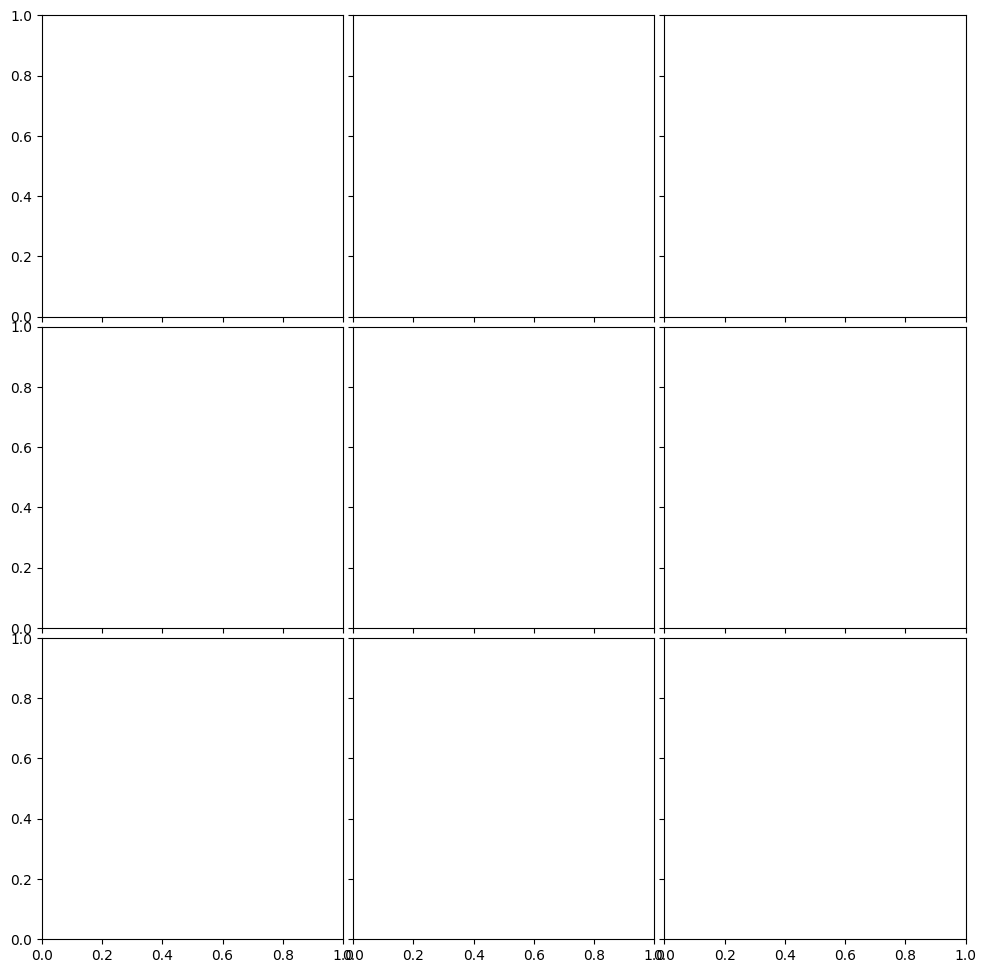

interactive(children=(IntText(value=0, description='i'), FloatSlider(value=0.0, description='aw0', max=10.0, m…

<function __main__.data_interact_bb(i, aw0, daw, hfov, vfov, offset, tilt)>

In [ ]:
def data_interact_bb(i, aw0, daw, hfov, vfov, offset, tilt):
    show_imgs_w_bbs(data_ims)

interact(data_interact_bb,
         aw0=widgets.FloatSlider(min=-10, max=10, step=1, value=0),
         daw=widgets.FloatSlider(min=13000, max=18000, step=200, value=17000),
         hfov=widgets.FloatSlider(min=78, max=82, step=0.2, value=80),
         vfov=widgets.FloatSlider(min=40, max=52, step=0.25, value=50.75),
         offset=widgets.FloatSlider(min=-10, max=10, step=0.25, value=0),
         tilt=widgets.FloatSlider(min=-2, max=0, step=0.05, value=-1.25),
         i=widgets.IntText(value=0))